In [2]:
import pymongo
import numpy as np
import matplotlib.pyplot as plt

from dateutil import parser
from wordcloud import WordCloud
from scripts import MONGO_URL
from scripts.analysis import data, plot

plot.init_matplotlib()


def get_corpus(repo_names: list[str]) -> tuple[dict[str, int], list[list[str]]]:
    word_freq = {}
    text_corpora = []
    for repo in repo_names:
        repo_name = repo.split("/")[1]
        text = []
        for x in repo_name.split("-"):
            for y in x.split("_"):
                for word in y.split("."):
                    if len(word) <= 1:
                        continue
                    word = word.lower()
                    if word in word_freq:
                        word_freq[word] += 1
                        text.append(word)
                    else:
                        word_freq[word] = 1
                        text.append(word)
        if len(text) > 0:
            text_corpora.append(text)
    return word_freq, text_corpora

In [3]:
repos = data.get_fake_star_repos()
repos_with_campaign = data.get_repos_with_campaign()
repos = repos[repos.repo_name.isin(repos_with_campaign)]
print(len(repos[repos.repo_id.notna()]), len(repos[repos.repo_id.isna()]))

1783 16834


[('2024', 1408), ('bot', 1149), ('free', 874), ('crack', 725), ('pro', 665), ('adobe', 627), ('auto', 535), ('activation', 469), ('autoclicker', 449), ('hack', 362), ('executor', 323), ('crypto', 320), ('cracked', 264), ('ai', 262), ('cheat', 260), ('version', 258), ('roblox', 256), ('wallet', 250), ('studio', 244), ('generator', 244), ('download', 236), ('main', 232), ('tool', 225), ('for', 211), ('h4ck', 197), ('premium', 195), ('app', 184), ('trading', 184), ('photoshop', 177), ('discord', 172), ('fl', 170), ('script', 163), ('by', 158), ('full', 156), ('solara', 155), ('clicker', 151), ('menu', 147), ('solana', 144), ('blum', 142), ('sniper', 136), ('vpn', 124), ('video', 121), ('apex', 118), ('game', 118), ('pc', 117), ('fr33', 116), ('rust', 116), ('view', 113), ('hamster', 110), ('seed', 106)]


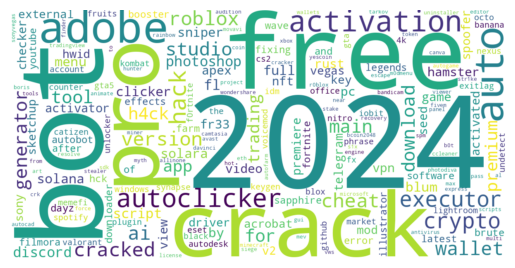

In [4]:
word_freq, text_corpora = get_corpus(repos_with_campaign)
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:50])
wordcloud = WordCloud(
    width=1200, height=600, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("plots/wordcloud.pdf", bbox_inches="tight")

[('2024', 1382), ('bot', 1071), ('free', 856), ('crack', 721), ('pro', 656), ('adobe', 618), ('auto', 528), ('activation', 467), ('autoclicker', 438), ('hack', 357), ('executor', 321), ('crypto', 312), ('cracked', 263), ('cheat', 256), ('version', 254), ('roblox', 252), ('ai', 245), ('wallet', 241), ('studio', 239), ('generator', 235), ('download', 234), ('main', 226), ('tool', 216), ('for', 200), ('h4ck', 196), ('premium', 192), ('photoshop', 177), ('trading', 175), ('fl', 168), ('discord', 163), ('script', 160), ('app', 159), ('by', 157), ('solara', 154), ('full', 151), ('clicker', 148), ('menu', 147), ('blum', 141), ('vpn', 121), ('apex', 117), ('video', 117), ('sniper', 116), ('solana', 116), ('fr33', 113), ('pc', 113), ('hamster', 109), ('game', 109), ('rust', 107), ('view', 106), ('activator', 105), ('activated', 104), ('seed', 103), ('premiere', 101), ('checker', 100), ('nft', 96), ('spoofer', 94), ('vegas', 93), ('sony', 91), ('sketchup', 87), ('key', 87), ('mod', 86), ('hwid',

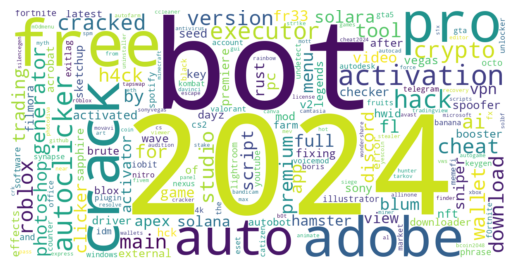

In [7]:
# deleted repos
word_freq, text_corpora = get_corpus(
    repos_with_campaign & set(repos[repos.repo_id.isna()].repo_name)
)
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:100])
wordcloud = WordCloud(
    width=1200, height=600, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("plots/wordcloud-deleted.pdf", bbox_inches="tight")

[('bot', 77), ('sdk', 32), ('telegram', 31), ('solana', 29), ('2024', 24), ('api', 24), ('app', 24), ('did', 22), ('github', 21), ('project', 20), ('sniper', 19), ('android', 18), ('web', 17), ('ai', 17), ('server', 17), ('token', 17), ('free', 16), ('products', 16), ('dart', 15), ('face', 14)]


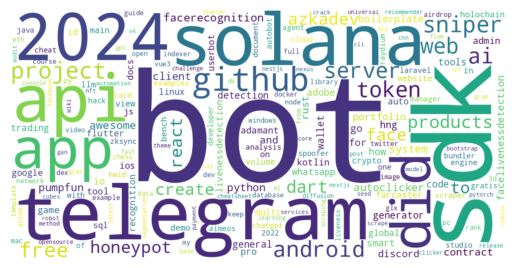

In [ ]:
word_freq, text_corpora = get_corpus(
    repos_with_campaign & set(repos[repos.repo_id.notna()].repo_name)
)
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20])
wordcloud = WordCloud(
    width=1200, height=600, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("plots/wordcloud-nondeleted.pdf", bbox_inches="tight")

[('bot', 52), ('telegram', 29), ('api', 22), ('web', 17), ('app', 16), ('github', 16), ('products', 16), ('dart', 15), ('azkadev', 14), ('sdk', 14), ('ai', 13), ('awesome', 12), ('to', 12), ('sniper', 12), ('project', 11), ('python', 11), ('face', 10), ('tools', 9), ('android', 9), ('token', 9)]


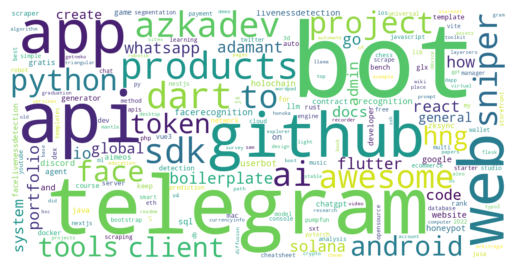

In [ ]:
word_freq, text_corpora = get_corpus(
    repos_with_campaign
    & set(repos[repos.repo_id.notna() & (repos.active_days >= 90)].repo_name)
)
print(sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20])
wordcloud = WordCloud(
    width=1200, height=600, background_color="white", colormap="viridis"
).generate_from_frequencies(word_freq)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig("plots/wordcloud-nondeleted.pdf", bbox_inches="tight")

In [ ]:
repos[repos.repo_id.notna() & (repos.active_days >= 30)]

,repo_id,repo_name,n_stars,n_stars_latest,n_stars_low_activity,p_stars_low_activity,n_stars_clustered,p_stars_clustered,p_stars_fake,active_days
58,R_kgDOLepIDQ,Abdullahaqee/life4u,59.0,22.0,0.0,0.0,59.0,1.000000,1.000000,77
102,R_kgDOL_l2LQ,ginhenrick/CTDL-GT_DoAnCuoiKi,477.0,103.0,0.0,0.0,477.0,1.000000,1.000000,66
154,R_kgDOLlt6kA,sflimbusfisufzs/wisper,171.0,68.0,0.0,0.0,171.0,1.000000,1.000000,79
163,R_kgDOLmru1A,Abdullahaqee/TODOAPP,55.0,21.0,0.0,0.0,55.0,1.000000,1.000000,60
202,R_kgDOLn1n9Q,ginhenrick/wordpad,484.0,103.0,0.0,0.0,484.0,1.000000,1.000000,123
...,...,...,...,...,...,...,...,...,...,...
22150,R_kgDOKX2BYQ,ethstorage/es-node,946.0,799.0,0.0,0.0,105.0,0.110994,0.110994,415
22218,MDEwOlJlcG9zaXRvcnkxNTQ3OTczOTE=,Adamant-im/ETH-transactions-storage,647.0,576.0,0.0,0.0,68.0,0.105100,0.105100,1955
22244,MDEwOlJlcG9zaXRvcnkxNjIyNzY4OTQ=,Wilfred/difftastic,19161.0,21570.0,0.0,0.0,1968.0,0.102709,0.102709,1872
22248,MDEwOlJlcG9zaXRvcnkyMTc0NjkwMzM=,sangminwoo/awesome-vision-and-language,508.0,516.0,0.0,0.0,52.0,0.102362,0.102362,1644


In [ ]:
import re
import nltk
import gensim
import pandas as pd
from pprint import pprint
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


nltk.download("stopwords")
nltk.download("punkt")
nltk.download("punkt_tab")

stop_words = set(stopwords.words("english"))


def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\W|\d", " ", text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    tokens = simple_preprocess(" ".join(tokens), deacc=True)
    return tokens


long_living_repos = repos[repos.repo_id.notna() & (repos.active_days >= 90)]
readmes = pd.read_csv("data/readmes/summary.csv")
readmes["content"] = readmes.readme.map(lambda x: open(x).read())
readmes = readmes[readmes.repo.isin(long_living_repos.repo_name)]

processed_readme_conent = [preprocess_text(text) for text in readmes.content]
processed_readme_conent = [text for text in processed_readme_conent if len(text) > 0]
id2word = Dictionary(processed_readme_conent)
id2word.filter_extremes(no_below=5, no_above=0.5)
corpus = [id2word.doc2bow(text) for text in processed_readme_conent]
print("Sample Dictionary (id2word):", list(id2word.items())[:10])
print("Sample Corpus entry:", corpus[0][:10])

[nltk_data] Downloading package stopwords to /home/haohe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/haohe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/haohe/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Sample Dictionary (id2word): [(0, 'accept'), (1, 'account'), (2, 'adapted'), (3, 'add'), (4, 'alert'), (5, 'already'), (6, 'also'), (7, 'appears'), (8, 'application'), (9, 'area')]
Sample Corpus entry: [(0, 2), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


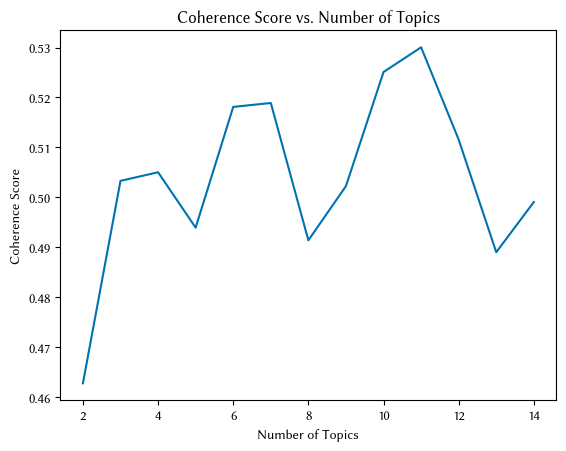

Number of Topics = 2, Coherence Score = 0.4627324937680535
Number of Topics = 3, Coherence Score = 0.5032925596380514
Number of Topics = 4, Coherence Score = 0.5050143270602575
Number of Topics = 5, Coherence Score = 0.49392181445763705
Number of Topics = 6, Coherence Score = 0.5181048984890445
Number of Topics = 7, Coherence Score = 0.5188933212002228
Number of Topics = 8, Coherence Score = 0.49138319141931286
Number of Topics = 9, Coherence Score = 0.5022397402421892
Number of Topics = 10, Coherence Score = 0.5250928776212809
Number of Topics = 11, Coherence Score = 0.5300490409931108
Number of Topics = 12, Coherence Score = 0.511558533194001
Number of Topics = 13, Coherence Score = 0.4889909239560511
Number of Topics = 14, Coherence Score = 0.4990505700942376


In [ ]:
import gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            update_every=1,
            passes=10,
            alpha="auto",
            per_word_topics=True,
        )
        model_list.append(model)

        coherence_model = CoherenceModel(
            model=model, texts=texts, dictionary=dictionary, coherence="c_v"
        )
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values


start = 2  # Minimum number of topics
limit = 15  # Maximum number of topics
step = 1  # Step size for the number of topics

model_list, coherence_values = compute_coherence_values(
    dictionary=id2word,
    corpus=corpus,
    texts=processed_readme_conent,
    start=start,
    limit=limit,
    step=step,
)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

for m, cv in zip(x, coherence_values):
    print(f"Number of Topics = {m}, Coherence Score = {cv}")

In [ ]:
def lda_to_dataframe(model, num_words=10):
    num_topics = model.num_topics
    topic_data = {"Topic": [], "Num_Docs": []}
    for i in range(num_words):
        topic_data[f"Word_{i+1}"] = []
    for topic_num in range(num_topics):
        words = model.show_topic(topic_num, topn=num_words)
        for i, (word, weight) in enumerate(words):
            topic_data[f"Word_{i+1}"].append(word + f" ({weight:.2f})")
        for i in range(len(words), num_words):
            topic_data[f"Word_{i+1}"].append(None)
        num_docs_in_topic = sum(
            1 for doc in corpus if doc and max(doc, key=lambda x: x[1])[0] == topic_num
        )
        topic_data["Topic"].append(f"Topic {topic_num}")
        topic_data["Num_Docs"].append(num_docs_in_topic)
    df = pd.DataFrame(topic_data)
    return df


model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=42,
    update_every=1,
    passes=10,
    alpha="auto",
    per_word_topics=True,
)

lda_to_dataframe(model)

,Topic,Num_Docs,Word_1,Word_2,Word_3,Word_4,Word_5,Word_6,Word_7,Word_8,Word_9,Word_10
0,Topic 0,0,sup (0.20),tls (0.12),day (0.02),university (0.02),cache (0.01),kotlin (0.01),language (0.01),github (0.01),arxiv (0.01),models (0.01)
1,Topic 1,2,src (0.06),img (0.05),href (0.04),alt (0.03),align (0.03),width (0.02),center (0.02),div (0.02),png (0.02),target (0.02)
2,Topic 2,0,data (0.02),cfg (0.02),class (0.02),src (0.02),true (0.02),width (0.01),view (0.01),size (0.01),config (0.01),img (0.01)
3,Topic 3,1,global (0.04),telegram (0.03),bot (0.03),corporation (0.02),cara (0.02),userbot (0.02),beli (0.02),center (0.01),align (0.01),allows (0.01)
4,Topic 4,0,data (0.03),model (0.01),models (0.01),open (0.01),library (0.01),analysis (0.01),python (0.01),using (0.01),based (0.01),prompt (0.01)
5,Topic 5,0,code (0.02),pdf (0.02),time (0.02),language (0.01),model (0.01),series (0.01),paper (0.01),understanding (0.01),learning (0.01),dataset (0.01)
6,Topic 6,0,data (0.01),import (0.01),model (0.01),github (0.01),string (0.01),function (0.01),name (0.01),calculation (0.01),use (0.01),class (0.01)
7,Topic 7,0,run (0.02),git (0.01),project (0.01),build (0.01),bash (0.01),file (0.01),dart (0.01),repository (0.01),zksync (0.01),yarn (0.01)
8,Topic 8,2,new (0.02),string (0.02),class (0.02),public (0.02),java (0.02),uygulama (0.01),int (0.01),network (0.01),math (0.01),data (0.01)
9,Topic 9,0,use (0.01),file (0.01),run (0.01),token (0.01),code (0.01),install (0.01),license (0.01),data (0.01),using (0.00),create (0.00)


In [ ]:
#Can GitHub tags tell us anything?
from tqdm import tqdm
from github import Github
from scripts import GITHUB_TOKENS

g = Github(GITHUB_TOKENS[0])
repo_tags = {}
repo_descriptions = {}
for repo_name in tqdm(long_living_repos.repo_name):
    try:
        repo = g.get_repo(repo_name)
        tags = repo.get_topics()
        repo_tags[repo_name] = [tag for tag in tags]
        repo_descriptions[repo_name] = repo.description
    except Exception as e:
        print(f"Error fetching tags for {repo_name}: {e}")
        repo_tags[repo_name] = None
long_living_repos = long_living_repos.copy()
long_living_repos["tags"] = long_living_repos.repo_name.map(lambda x: repo_tags.get(x))
long_living_repos["description"] = long_living_repos.repo_name.map(lambda x: repo_descriptions.get(x))
long_living_repos.to_csv("data/long_living_repos.csv", index=False)

100%|██████████| 1129/1129 [14:10<00:00,  1.33it/s]
